# Local explainability

A couple of interesting examples of SHAP and DALEX for local explainability and model fairness.

## Imports and config

In [1]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

import dalex as dx
import pandas as pd 
import numpy as np
import shap
import xgboost

/home/bhernandez/Documents/pydata2023/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.set_option('display.max_columns', None)

## Load data

In [3]:
X, y = shap.datasets.nhanesi()
X_display, y_display = shap.datasets.nhanesi(display=True) # human readable feature values

In [68]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14264 entries, 20751 to 25061
Data columns (total 79 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   sex_isFemale                             14264 non-null  bool   
 1   age                                      14264 non-null  int64  
 2   physical_activity                        14264 non-null  int64  
 3   serum_albumin                            10671 non-null  float64
 4   alkaline_phosphatase                     6321 non-null   float64
 5   alkaline_phosphatase_isUnacceptable      14264 non-null  bool   
 6   alkaline_phosphatase_isTestnotdone       14264 non-null  bool   
 7   SGOT                                     6275 non-null   float64
 8   SGOT_isUnacceptable                      14264 non-null  bool   
 9   SGOT_isTestnotdone                       14264 non-null  bool   
 10  BUN                                      2

## Model

Usamos un modelo de árboles que admite nulos (lat, lon tiene muchos nulos).

In [5]:
xgb_full = xgboost.DMatrix(X, label=y)
# train final model on the full data set
params = {
    "eta": 0.002,
    "max_depth": 3,
    "objective": "survival:cox",
    "subsample": 0.5
}
model = xgboost.train(params, xgb_full, 5000, evals = [(xgb_full, "test")], verbose_eval=1000)

[0]	test-cox-nloglik:9.28408
[1000]	test-cox-nloglik:8.60854
[2000]	test-cox-nloglik:8.53116
[3000]	test-cox-nloglik:8.49403
[4000]	test-cox-nloglik:8.47058
[4999]	test-cox-nloglik:8.45255


## Explainability

SHAP Explainability for the model. 
El explainer (todas las variantes) crean el modelo con los valores Shapley para explicar el modelo.

In [6]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
explanations = explainer(X)

In [7]:
print('--Explainer model--')
print(explainer)
print(type(explainer))
print('--Shap values--')
print(shap_values)
print(type(shap_values))
print('--Explainer dataframe--')
print(explanations)
print(type(explanations))

--Explainer model--
<class 'shap.explainers._tree.Tree'>
--Shap values--
[[ 1.84628233e-01 -5.04557610e-01 -3.13231274e-02 ... -1.92297876e-01
  -1.64051000e-02 -5.78483492e-02]
 [ 1.66194662e-01 -1.09421897e+00  5.98950498e-02 ... -2.91730892e-02
  -6.48942171e-03 -4.91099022e-02]
 [-1.49643376e-01 -1.56533003e+00  7.20566958e-02 ... -1.84312284e-01
   3.18674967e-02 -3.89468074e-02]
 ...
 [-2.05180049e-01 -9.24388349e-01  6.81497306e-02 ... -2.10007086e-01
   2.53346898e-02  3.22342068e-01]
 [-2.38794148e-01  3.31081092e-01 -2.36861296e-02 ...  2.89917737e-01
  -2.62622605e-04 -6.56308085e-02]
 [ 1.60021782e-01 -1.59773672e+00 -2.64430381e-02 ...  1.45278588e-01
  -1.00701945e-02  1.04265157e-02]]
<class 'numpy.ndarray'>
--Explainer dataframe--
.values =
array([[ 1.84628233e-01, -5.04557610e-01, -3.13231274e-02, ...,
        -1.92297876e-01, -1.64051000e-02, -5.78483492e-02],
       [ 1.66194662e-01, -1.09421897e+00,  5.98950498e-02, ...,
        -2.91730892e-02, -6.48942171e-03, -4.

### Global

Explicabilidad del conjunto de las predicciones. Como lo hacemos sobre el dataset de entrenamiento sería lo más parecido a la explicabilidad global de SHAP.

/home/bhernandez/Documents/pydata2023/venv/lib/python3.8/site-packages/shap/plots/_beeswarm.py:664: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



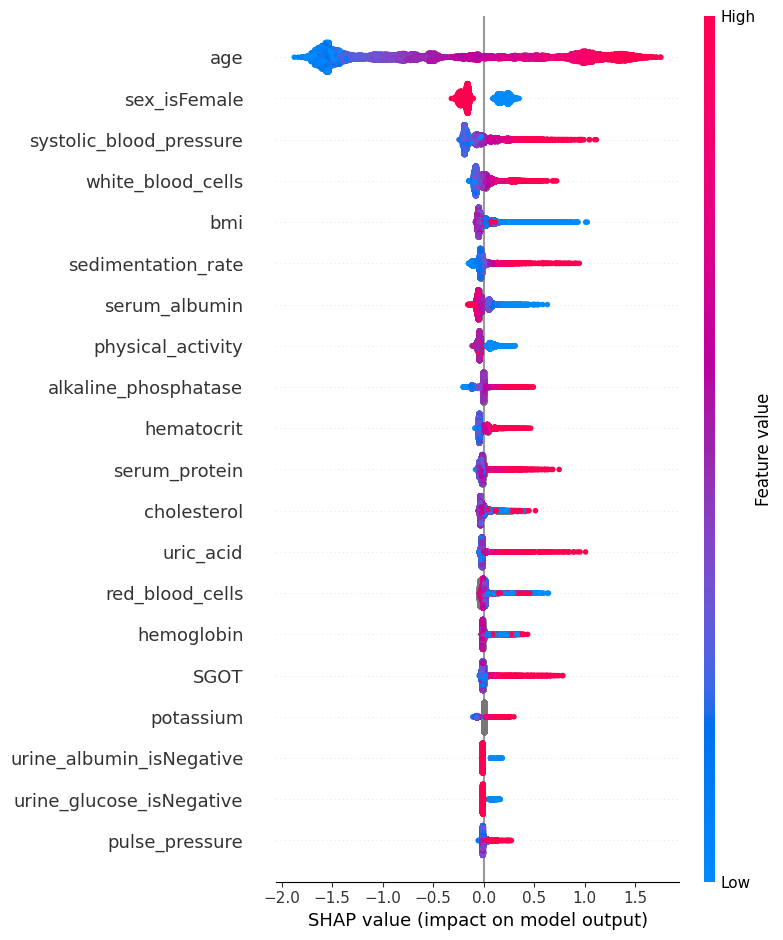

In [75]:
shap.summary_plot(shap_values, X)

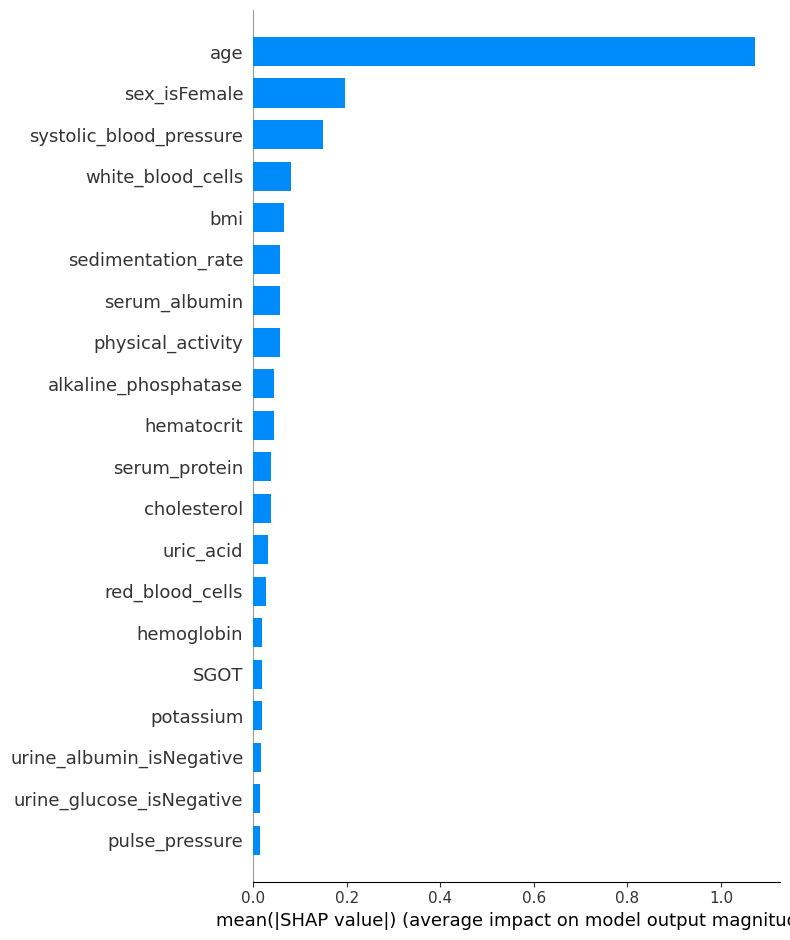

In [74]:
shap.summary_plot(shap_values, X, plot_type='bar')

`summary_plot` nos da la contribución de las variables en el entrenamiento usando SHAP values. Un plot más sencillo sería de barras (más parecido al feature importance).

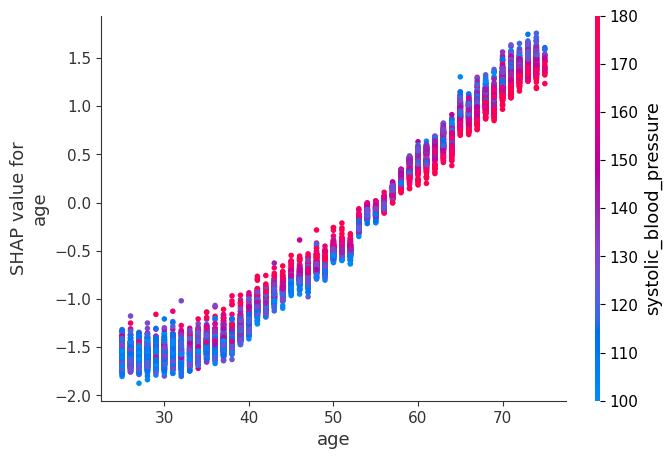

In [10]:
shap.dependence_plot("age", shap_values, X)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


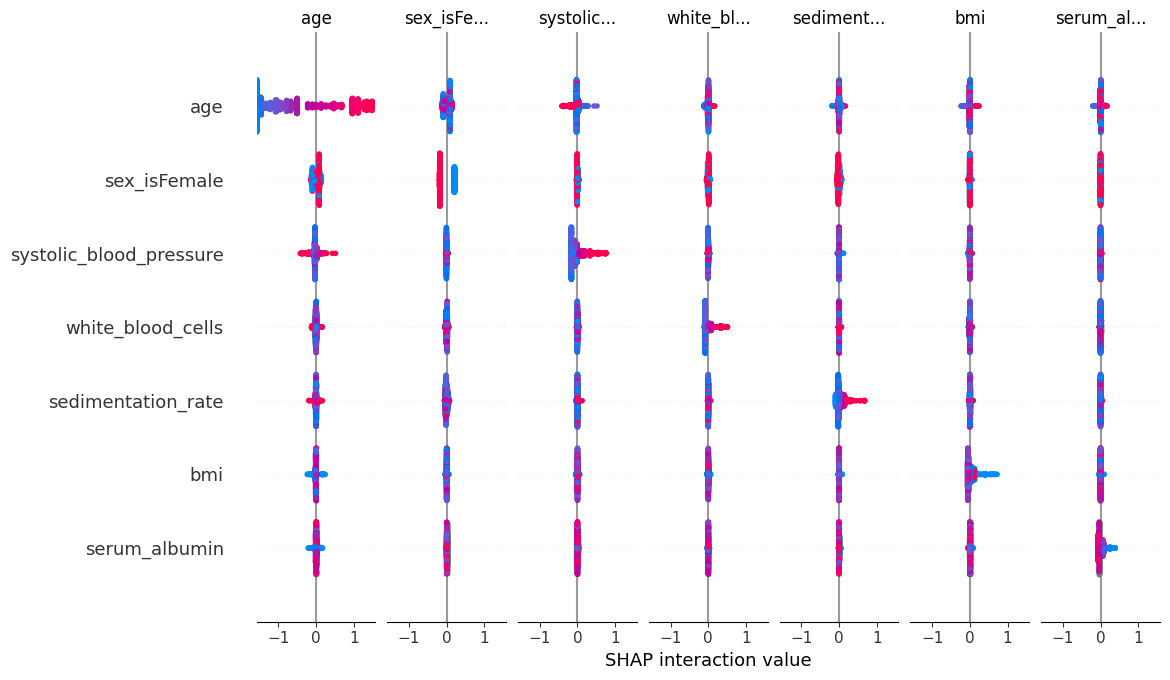

In [11]:
shap.summary_plot(explainer.shap_interaction_values(X[:1000]), X[:1000])

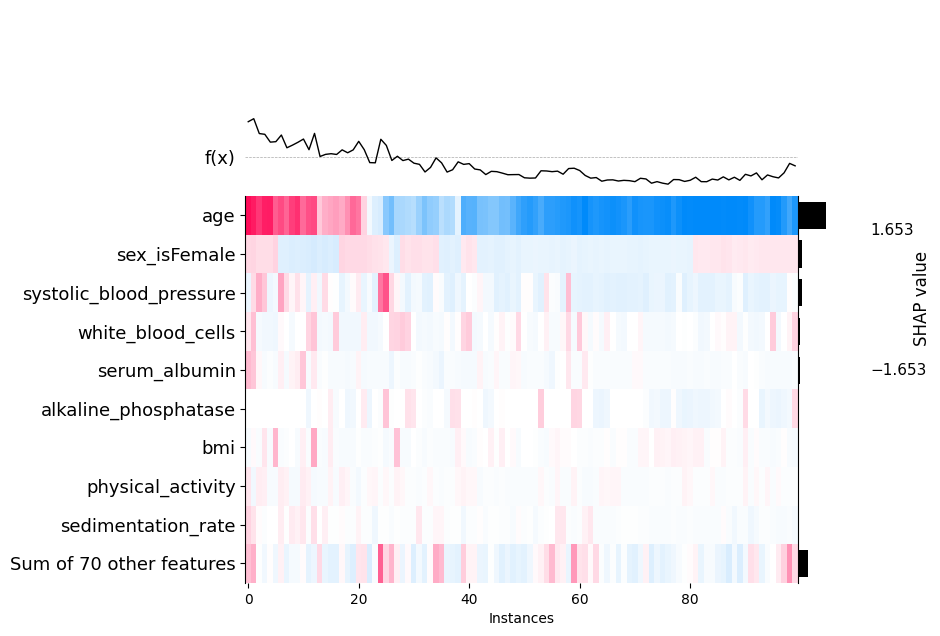

In [12]:
shap.plots.heatmap(explanations[:100])

### Local

In [72]:
shap.force_plot(explainer.expected_value, shap_values[0], X.iloc[0])

The expected value is  -0.6702478


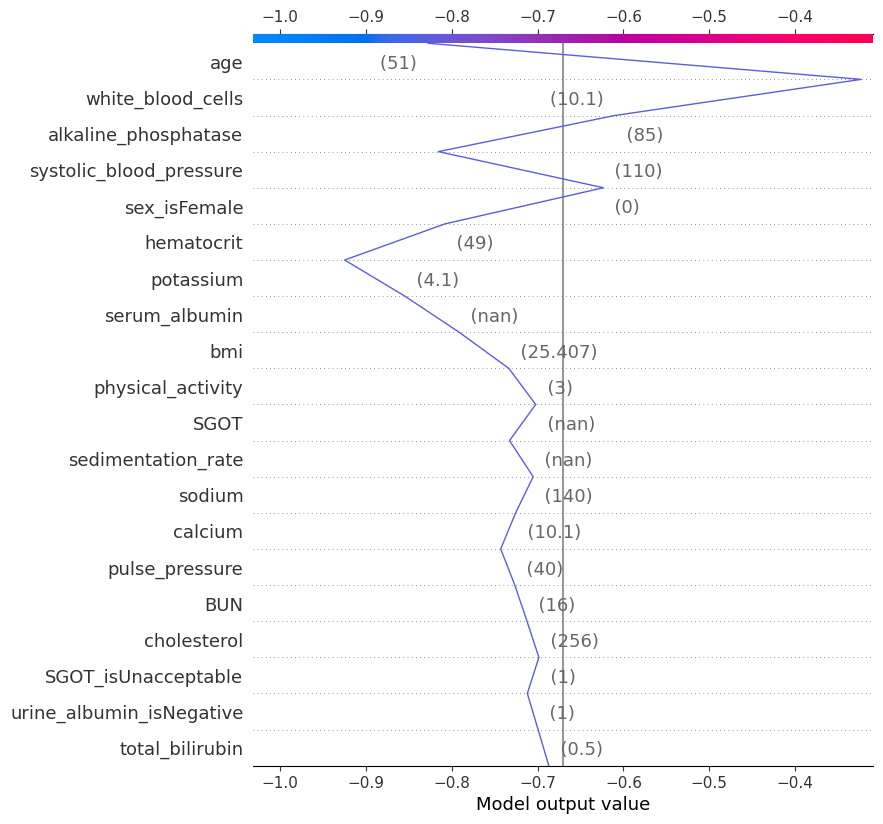

In [15]:
expected_value = explainer.expected_value
print("The expected value is ", expected_value)
shap.decision_plot(expected_value, shap_values[0], X)

### Fairness

In [32]:
exp = dx.Explainer(model, X, y, model_type='regression')

Preparation of a new explainer is initiated

  -> data              : 14264 rows 79 cols
  -> target variable   : 14264 values
  -> model_class       : xgboost.core.Booster (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_xgboost at 0x7f8f1799bd30> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.0401, mean = 0.897, max = 47.5
  -> model type        : regression will be used
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -45.3, mean = -10.1, max = 21.3
  -> model_info        : package xgboost

A new explainer has been created!


In [33]:
exp.model_performance()

,mse,rmse,r2,mae,mad
Booster,291.318597,17.068058,-0.408186,16.027404,18.39682


In [64]:
protected_ft = X.apply(
    lambda x: f"{np.where(np.logical_and(x['bmi'] > 18.5, x['bmi'] < 25), 'good', 'bad')}_{np.where(x['age'] < 51, 'young', 'old')}", 
    axis=1)
print(protected_ft)
privileged = "good_young"

20751       bad_old
20753    good_young
20754    good_young
20755     bad_young
20756    good_young
            ...    
25043       bad_old
25046      good_old
25049     bad_young
25057       bad_old
25061     bad_young
Length: 14264, dtype: object


In [65]:
fobject = exp.model_fairness(protected=protected_ft, privileged=privileged)
fobject.fairness_check(epsilon = 0.8)

Bias detected in 2 metrics: independence, separation

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'good_young'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
           independence  separation  sufficiency
subgroup                                        
bad_old        5.554721    4.867573     1.002977
bad_young      1.020601    1.017430     1.000625
good_old       4.632365    4.204163     0.992540


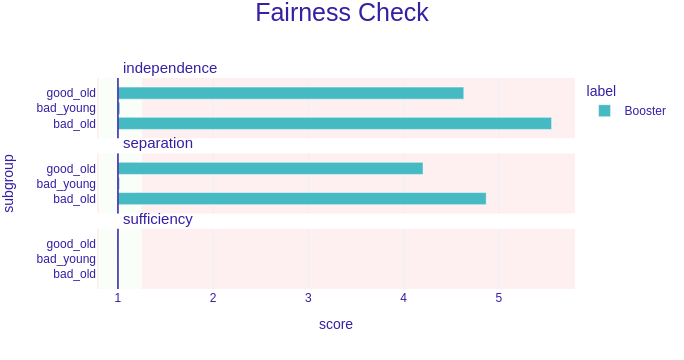

In [66]:
fobject.plot()